In [1]:
# !export JAX_PLATFORMS=cpu
import tszpower
import jax
import jax.numpy as jnp
import candl
import candl.interface
import candl.tools
import candl.plots
import candl.data
# from classy_sz import Class as Class_sz
candl.plots.set_plot_style()# Set the plot style (font sizes, tick widths, ...)

import optax
import blackjax
from datetime import date

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
from getdist import MCSamples

/Users/licongxu/envs/jax_env/lib/python3.12/site-packages/jax/_src/api_util.py:691: DeprecationWarning: Passing arguments 'a', 'a_min' or 'a_max' to jax.numpy.clip is deprecated. Please use 'arr', 'min' or 'max' respectively instead.
  ans = _fun(*args, **kwargs)
/Users/licongxu/envs/jax_env/lib/python3.12/site-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/Users/licongxu/envs/jax_env/lib/python3.12/site-packages/tensorflow_probability/python/__init__.py:58: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(required_tensorflow_version)):


In [2]:
# Define your parameter dictionaries:
cosmo_params = {
    "omega_b": 0.0224,
    "omega_cdm": 0.12,
    "H0": 69.,
    # "tau_reio": 0.06,
    "ln10_10A_s": 3.05321,
    "n_s": 0.96,
    "B": 1.41,
}

nuisance_params = {
    "A_cib": 0.66,
    "A_ir": 2.04,
    "A_rs": 0.0004,
}

# classy_sz = Class_sz()
# classy_sz.set(all_params)


all_params = {
    # "omega_b": 0.0224,
    # "omega_cdm": 0.12,
    # "H0": 69.,
    # "tau_reio": 0.06,
    # "ln10_10A_s": 3.055,
    # "n_s": 0.96,
    "B": 1.4,
    "A_cib": 0.66,
    "A_ir": 2.04,
    "A_rs": 0.0004,
}


# print(all_params)
# Preserve the order of parameters
param_names = list(cosmo_params.keys()) + list(nuisance_params.keys())

# Convert dictionary to list
# all_params_list = jnp.array([cosmo_params[p] for p in cosmo_params] + 
#                            [nuisance_params[p] for p in nuisance_params])
all_params_list = jnp.array([all_params[p] for p in all_params])
print(all_params_list)

# loglike = tszpower.likelihood(all_params)
# print("Log-likelihood:", loglike)

[1.40e+00 6.60e-01 2.04e+00 4.00e-04]


In [3]:
# Wrap the likelihood function.
@jax.jit
def loglike_pytree(allparams):
    omega_b = 0.0224
    omega_cdm = 0.12
    omega_m = {'omega_b': omega_b, 'omega_cdm': omega_cdm,
                   "H0": 69.,
    # "tau_reio": 0.06,
    "ln10_10A_s": 3.055,
    "n_s": 0.96,}
    all_params = {**omega_m, **allparams}
    # Here the likelihood function is assumed to be jax-compatible.
    return tszpower.likelihood(all_params)


In [4]:
loglike_pytree(all_params)

Array(-335.23551732, dtype=float64)

In [5]:
jacobian_loglike = jax.jacfwd(loglike_pytree)
jac_val = jacobian_loglike(all_params)

In [6]:
jac_val

{'A_cib': Array(-2157.24929069, dtype=float64),
 'A_ir': Array(-612.90915678, dtype=float64),
 'A_rs': Array(-539.82039129, dtype=float64),
 'B': Array(5269.15752841, dtype=float64)}

In [7]:
hess_loglike = jax.hessian(loglike_pytree)
hess_val = hess_loglike(all_params)


In [8]:
hess_val

{'A_cib': {'A_cib': Array(-5940.43446562, dtype=float64, weak_type=True),
  'A_ir': Array(-1539.8140865, dtype=float64, weak_type=True),
  'A_rs': Array(-1455.67562843, dtype=float64, weak_type=True),
  'B': Array(15233.09918482, dtype=float64, weak_type=True)},
 'A_ir': {'A_cib': Array(-1539.8140865, dtype=float64, weak_type=True),
  'A_ir': Array(-490.11459468, dtype=float64, weak_type=True),
  'A_rs': Array(-393.00550173, dtype=float64, weak_type=True),
  'B': Array(3690.22268941, dtype=float64, weak_type=True)},
 'A_rs': {'A_cib': Array(-1455.67562843, dtype=float64, weak_type=True),
  'A_ir': Array(-393.00550173, dtype=float64, weak_type=True),
  'A_rs': Array(-361.06582314, dtype=float64, weak_type=True),
  'B': Array(3732.30248465, dtype=float64, weak_type=True)},
 'B': {'A_cib': Array(15233.09918482, dtype=float64, weak_type=True),
  'A_ir': Array(3690.22268941, dtype=float64, weak_type=True),
  'A_rs': Array(3732.30248465, dtype=float64, weak_type=True),
  'B': Array(-59825.75

In [9]:
# We want to minimise all parameters - cosmological ones and nuisance parameters
# cosmo_pars_for_min = ["omega_b", "omega_cdm", "H0", "ln10_10A_s", "n_s", "B"]
cosmo_pars_for_min = [ "B"]
# cosmo_pars_for_min = ["B"]
nuisance_pars_for_min = ["A_cib", "A_ir", "A_rs"] 
pars_for_min = cosmo_pars_for_min + nuisance_pars_for_min


# Set the fiducial starting point
starting_pars = deepcopy(all_params)

# Step through minimiser
newton_points, newton_par_covs = candl.tools.newton_raphson_minimiser(like_deriv = jacobian_loglike ,# Derivative function
                                                                 like_hess = hess_loglike,# Hessian function
                                                                 starting_pars = starting_pars,# Start point
                                                                 pars_for_min = pars_for_min,# Which parameters to minimise
                                                                 N_newton = 20,# How many steps to take
                                                                 show_progress = True)# Show loading bars

  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
print("Newton points:", newton_points)
print("Newton covariances:", newton_par_covs)
print("Diagonal of the covariance matrix:", jnp.diag(newton_par_covs[-1]))

Newton points: [{'B': 1.4, 'A_cib': 0.66, 'A_ir': 2.04, 'A_rs': 0.0004}, {'B': Array(1.39828655, dtype=float64), 'A_cib': Array(0.66828277, dtype=float64), 'A_ir': Array(1.97487999, dtype=float64), 'A_rs': Array(-0.27883909, dtype=float64)}, {'B': Array(1.39628798, dtype=float64), 'A_cib': Array(0.67620246, dtype=float64), 'A_ir': Array(1.92752639, dtype=float64), 'A_rs': Array(-0.5192131, dtype=float64)}, {'B': Array(1.39399222, dtype=float64), 'A_cib': Array(0.68398731, dtype=float64), 'A_ir': Array(1.89495642, dtype=float64), 'A_rs': Array(-0.73053599, dtype=float64)}, {'B': Array(1.39140176, dtype=float64), 'A_cib': Array(0.69180136, dtype=float64), 'A_ir': Array(1.87470815, dtype=float64), 'A_rs': Array(-0.9203977, dtype=float64)}, {'B': Array(1.38853843, dtype=float64), 'A_cib': Array(0.69973408, dtype=float64), 'A_ir': Array(1.86467693, dtype=float64), 'A_rs': Array(-1.09436462, dtype=float64)}, {'B': Array(1.38544691, dtype=float64), 'A_cib': Array(0.70780873, dtype=float64), '

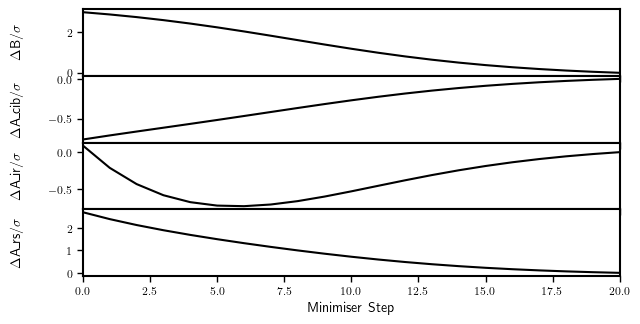

In [11]:
plt.close()
candl.plots.plot_minimiser_convergence(newton_points,
                                       par_cov=newton_par_covs[-1],
                                       par_cov_order=pars_for_min,
                                       relative=True)
plt.show()

In [12]:
# print(newton_par_covs[-1]**2)

In [13]:
import numpy as np
# para_cov = np.loadtxt("tszpower_chain_full.covmat")
# newton_par_covs[-1] = para_cov 
para_cov = newton_par_covs[-1]
# para_cov.shape

In [14]:
# Grab expected size of parameter errors based on Fisher matrix
# par_scales = {}
# for i, p in enumerate(pars_for_min):
#     par_scales[p] = jnp.sqrt(newton_par_covs[-1][i,i])
#     # par_scales[p] = jnp.sqrt(newton_par_covs[-1][i,i])
epsilon = 1e-12  # a small positive value to avoid sqrt of negative number
par_scales = {}
for i, p in enumerate(pars_for_min):
    var = newton_par_covs[-1][i, i]
    par_scales[p] = jnp.sqrt(jnp.maximum(var, epsilon))

# Helper functions to move from regular units to N(0,1)
def transform_to_zero_mean_unit_var(par_dict):
    new_par_dict = {}
    for p in par_dict:
        if p in all_params and p in par_scales:
            new_par_dict[p] = jnp.array((par_dict[p] - all_params[p])/par_scales[p], float)
    return new_par_dict

def transform_from_zero_mean_unit_var(par_dict):
    new_par_dict = {}
    for p in par_dict:
        if p in all_params and p in par_scales:
            new_par_dict[p] = jnp.array(all_params[p] + par_dict[p]*par_scales[p], float)
    return new_par_dict

# Here, we grab a function that moves from normed parameters to logl all in one step.
like_normed = lambda p: -1.0*loglike_pytree(transform_from_zero_mean_unit_var(p))# ADAM uses a different sign convention (logl to be positive)
like_normed_deriv = jax.jacrev(like_normed)

In [15]:
# Initialise the ADAM minimiser and starting point
adam_optimiser = optax.adam(learning_rate = 0.05)
starting_pars = transform_to_zero_mean_unit_var(deepcopy(all_params))
opt_state = adam_optimiser.init(starting_pars)

# Keep hold of all points
adam_logl_vals = []
adam_eval_points = [transform_from_zero_mean_unit_var(starting_pars)]

# Minimise!
N_adam = 100# number of steps
pbar = tqdm(total=N_adam)# Start progress bar
this_pars = deepcopy(starting_pars)
# this_pars = deepcopy(pars_for_min)
for i_adam in range(N_adam):

    # Get like value and gradient
    this_logl = like_normed(this_pars)
    this_grad = like_normed_deriv(this_pars)

    # Pass information to optax to get next step of minimiser
    updates, opt_state = adam_optimiser.update(this_grad,
                                               opt_state,
                                               this_pars)
    
    # Apply updates to the parameters
    this_pars = optax.apply_updates(this_pars,
                                    updates)

    # Keep hold of scaled pars (in right units), logl, and increment progress bar
    adam_eval_points.append(transform_from_zero_mean_unit_var(this_pars))
    adam_logl_vals.append(this_logl)
    pbar.update(1)

adam_logl_vals.append(like_normed(this_pars))# grab final logl value
pbar.close()# close progress bar

  0%|          | 0/100 [00:00<?, ?it/s]

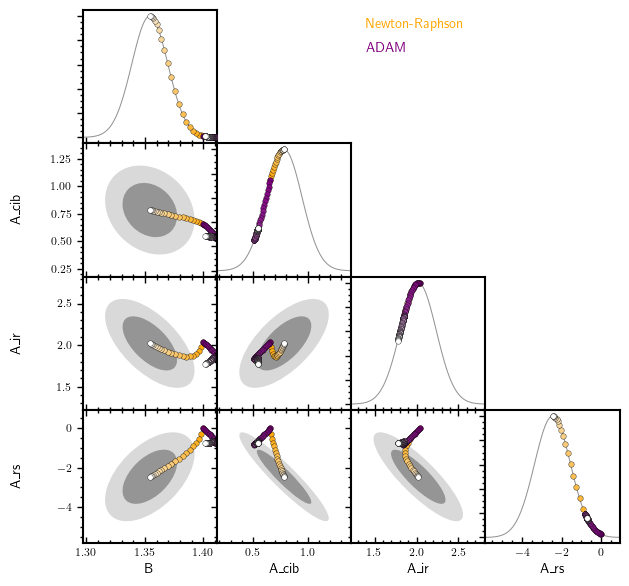

In [16]:
# Make a triangle plot and trace the journey of the two minimisers!
# You can see that while the two minimisers start at the same point they take very different journeys.
# ADAM's journey may seem erratic, but it tries to explore the parameter space more thoroughly to make sure
# it does not get stuck in a local minimum.
import numpy as np
# Only plot cosmological parameters
# pars_to_plot = ["omega_b", "omega_cdm", "H0", "ln10_10A_s", "n_s", "B","A_cib", "A_ir", "A_rs"] 
pars_to_plot = ["B","A_cib", "A_ir", "A_rs"] 

plt.close()

# Plot parameters
sigma_plot_range = 3
sigma_levels = 2

ax = candl.plots.triangle_plot_from_cov(pars_to_plot = pars_to_plot,# which parameters to plot
                                        bf_point = newton_points[-1],# Newton best-fit point
                                        par_cov = para_cov,# the parameter covariance matrix
                                        pars_in_cov = pars_for_min,# the order of parameters in the covariance
                                        sigma_plot_range = sigma_plot_range,# sets the axes limits
                                        sigma_levels = sigma_levels)# how many sigma levels to plot

# Plot the Newton minimiser
candl.plots.add_min_trajectory(ax = ax,# axis instance
                               pars_to_plot = pars_to_plot,# which parameters to plot
                               eval_points = newton_points,# a list of all the points in the minimiser trajectory
                               par_cov = newton_par_covs[-1],# covariance of the best run - this is used to set the correct height in the 1d panels
                               pars_in_cov = pars_for_min,# the order of parameters in the covariance
                               bf_point = newton_points[-1],# the best-fit point - again used in the 1d panels
                               dark_colours=False,
                               base_colour = "orange")# the base colour used to show the trajectory path

# Plot the Adam minimiser
candl.plots.add_min_trajectory(ax = ax,# axis instance
                               pars_to_plot = pars_to_plot,# which parameters to plot
                               eval_points = adam_eval_points,# a list of all the points in the minimiser trajectory
                               par_cov = newton_par_covs[-1],# covariance of the best run - this is used to set the correct height in the 1d panels
                               pars_in_cov = pars_for_min,# the order of parameters in the covariance
                               bf_point = newton_points[-1],# the best-fit point - again used in the 1d panels
                               base_colour = "purple")# the base colour used to show the trajectory path

# Add a make-shift legend
ax[0,0].text(newton_points[-1][pars_to_plot[0]]+6*sigma_levels*np.sqrt(newton_par_covs[-1][0,0]),
             0.9,
             "Newton-Raphson",
             color="orange")
ax[0,0].text(newton_points[-1][pars_to_plot[0]]+6*sigma_levels*np.sqrt(newton_par_covs[-1][0,0]),
             0.7,
             "ADAM",
             color="purple")

plt.show()

In [17]:
# Wrap the likelihood in a function that takes in a vector of parameters (defined by pars_for_min)
def like_normed_vec(input_vec):
    par_dict = {pars_for_min[i]: input_vec[i] for i in range(len(pars_for_min))}
    # print(par_dict)
    nenormed_par_dict = transform_from_zero_mean_unit_var(par_dict)
    # print(nenormed_par_dict)
    return loglike_pytree(nenormed_par_dict)

# Define the inference loop
# This code is taken from the BlackJAX tutorial
def inference_loop(rng_key, kernel, initial_state, num_samples):

    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state
    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states

In [18]:
likelihood = like_normed_vec(all_params_list)
likelihood

Array(-821.56436814, dtype=float64)

In [26]:
# Run NUTS chains! This takes about a minute.
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))# grab random number for starting point
nuts = blackjax.nuts(like_normed_vec, step_size=1e-2, inverse_mass_matrix=np.ones(len(pars_for_min)))
initial_state = nuts.init(all_params_list)
states = inference_loop(rng_key,
                        nuts.step,
                        initial_state,
                        20)# Number of desired samples

In [27]:
# Restore units to samples and convert to a GetDist MCSamples object
fid_pars_vec = np.array([all_params[p] for p in pars_for_min])
def denorm_pars(pars):
    return pars*np.sqrt(np.diag(newton_par_covs[-1]))+fid_pars_vec
NUTS_samples = jnp.apply_along_axis(denorm_pars, 1, states.position)

gd_samples_NUTS = MCSamples(samples = np.array(NUTS_samples),
                            names = pars_for_min,
                            labels = [candl.plots.PAR_LABEL_DICT[p] if p in candl.plots.PAR_LABEL_DICT else p for p in pars_for_min],
                            label='BlackJAX NUTS')
gd_samples_NUTS.loglikes = np.zeros(20)# BlackJAX doesn't return logl values, we set these to zero here

In [28]:
states.position

Array([[ 1.37308476e+00,  5.98041926e-01,  1.98812111e+00,
        -1.48878097e-01],
       [ 1.37446750e+00,  5.83453369e-01,  1.97694583e+00,
        -1.60934239e-01],
       [ 1.39699078e+00,  5.20303307e-01,  1.97974981e+00,
        -2.77615623e-01],
       [ 1.52287541e+00,  2.14049530e-01,  1.93224462e+00,
        -7.26310389e-01],
       [ 1.56374253e+00, -2.99411141e-01,  1.77559732e+00,
        -1.35385089e+00],
       [ 1.57646393e+00, -4.06182342e-01,  1.68180297e+00,
        -1.45690416e+00],
       [ 8.30100272e-01, -3.34938835e-01,  1.28575432e+00,
        -1.62680518e+00],
       [ 6.50614632e-01,  1.53337441e-02,  9.56725127e-01,
        -1.75179698e+00],
       [ 6.55371497e-01, -7.32447033e-04,  9.43033739e-01,
        -1.78655812e+00],
       [ 2.50674068e-01, -1.90205991e-01,  7.21538105e-01,
        -1.68151970e+00],
       [ 2.22025515e-01, -1.84211677e-01,  6.77048220e-01,
        -1.66294117e+00],
       [-4.28317092e-01,  8.83543319e-02,  4.04642181e-01,
      

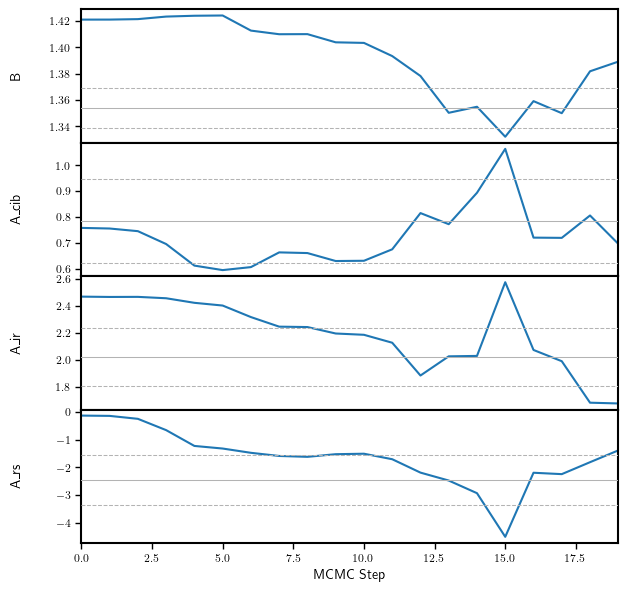

In [29]:
# Plot the NUTS samples!
# These are much less correlated than the MH samples from the traditional tutorial.
plt.close()
fig, ax = candl.plots.plot_mcmc_chain_steps(gd_samples_NUTS,# samples to plot
                                            list(all_params.keys()),# parameters to plot
                                            newton_points[-1],# best-fit point
                                            newton_par_covs[-1],# Fisher matrix from the Newton minimiser
                                            pars_for_min,# order of parameters in covariance matrix
                                            show_logl=False)# Order of paramters in the Fisher matrix
plt.show()